# 使用scipy.io下载 .mat文件
得到的是字典格式，键值对

In [1]:
import scipy.io as scio

E1 = scio.loadmat('./DB3/SIA_delsys_16_movements_data/S1_E1.mat')
E2 = scio.loadmat('./DB3/SIA_delsys_16_movements_data/S1_E2.mat')
E3 = scio.loadmat('./DB3/SIA_delsys_16_movements_data/S1_E3.mat')
E4 = scio.loadmat('./DB3/SIA_delsys_16_movements_data/S1_E4.mat')

print(E1.keys())
print(E2.keys())
print(E3.keys())
print(E4.keys())

dict_keys(['__header__', '__version__', '__globals__', 'emg', 'label'])
dict_keys(['__header__', '__version__', '__globals__', 'emg', 'label'])
dict_keys(['__header__', '__version__', '__globals__', 'emg', 'label'])
dict_keys(['__header__', '__version__', '__globals__', 'emg', 'label'])


# 合并E1，E2，E3，E4数据

In [4]:
import numpy as np

E1_emg = E1['emg']
E2_emg = E2['emg']
E3_emg = E3['emg']
E4_emg = E4['emg']

E1_label = E1['label']
E2_label = E2['label']
E3_label = E3['label']
E4_label = E4['label']

def getUsefulData(label, emg):
    idx = []
    for i in range(len(label)):
        if label[i] != 0:
            idx.append(i)
    return label[idx, :], emg[idx, :]

label1, emg1 = getUsefulData(E1_label, E1_emg)
label2, emg2 = getUsefulData(E2_label, E2_emg)
label2 += label1[-1, :]
label3, emg3 = getUsefulData(E3_label, E3_emg)
label3 += label2[-1, :]
label4, emg4 = getUsefulData(E4_label, E4_emg)
label4 += label3[-1, :]

emg = np.vstack((emg1, emg2, emg3, emg4))
label = np.vstack((label1, label2, label3, label4))
label -= 1

print(emg.shape)
print(label.shape)

(960096, 6)
(960096, 1)


[[ 0]
 [ 0]
 [ 0]
 ...
 [15]
 [15]
 [15]]


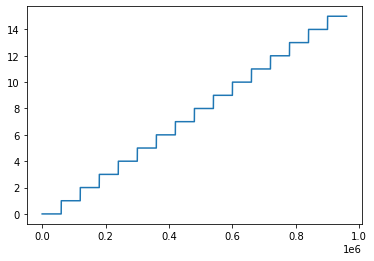

In [5]:
import matplotlib.pyplot as plt

print(label)
plt.plot(label)
plt.show()

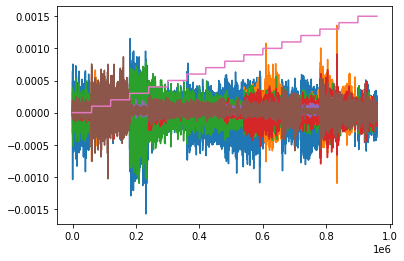

In [6]:
plt.plot(emg)
plt.plot(label*0.0001)
plt.show()

# 提取时域特征

In [8]:
from feature_utils import *  
import math

featureData = []
featureLabel = []
classes = 16
timeWindow = 200
strideWindow = 200

for i in range(classes):
    index = []
    for j in range(label.shape[0]):
        if label[j, :] == i:
            index.append(j)
    iemg = emg[index, :]
    length = math.floor((iemg.shape[0] - timeWindow) / strideWindow)
    print('[+] class {}, number of sample: {} {}'.format(i, iemg.shape[0], length))
    for j in range(length):
        rms = featureRMS(iemg[strideWindow*j:strideWindow*j+timeWindow, :])
        mav = featureMAV(iemg[strideWindow*j:strideWindow*j+timeWindow, :])
        wl = featureWL(iemg[strideWindow*j:strideWindow*j+timeWindow, :])
        zc = featureZC(iemg[strideWindow*j:strideWindow*j+timeWindow, :])
        ssc = featureSSC(iemg[strideWindow*j:strideWindow*j+timeWindow, :])
        featureStack = np.hstack((rms, mav, wl, zc, ssc))
        featureData.append(featureStack)
        featureLabel.append(i)
featureData = np.array(featureData)

print(featureData.shape)
print(len(featureLabel))

[+] class 0, number of sample: 60006 299
[+] class 1, number of sample: 60006 299
[+] class 2, number of sample: 60006 299
[+] class 3, number of sample: 60006 299
[+] class 4, number of sample: 60006 299
[+] class 5, number of sample: 60006 299
[+] class 6, number of sample: 60006 299
[+] class 7, number of sample: 60006 299
[+] class 8, number of sample: 60006 299
[+] class 9, number of sample: 60006 299
[+] class 10, number of sample: 60006 299
[+] class 11, number of sample: 60006 299
[+] class 12, number of sample: 60006 299
[+] class 13, number of sample: 60006 299
[+] class 14, number of sample: 60006 299
[+] class 15, number of sample: 60006 299
(4784, 30)
4784


# 构造成图像数据

In [9]:
imageData = []
imageLabel = []
imageLength = 200

for i in range(classes):
    index = []
    for j in range(label.shape[0]):
        if label[j, :] == i:
            index.append(j)
    iemg = emg[index, :]
    length = math.floor((iemg.shape[0] - imageLength) / imageLength)
    print('[+] class {}, number of sample: {} {}'.format(i, iemg.shape[0], length))
    for j in range(length):
        subImage = iemg[imageLength*j:imageLength*(j+1), :]
        imageData.append(subImage)
        imageLabel.append(i)

imageData = np.array(imageData)
print(imageData.shape)
print(len(imageLabel))

[+] class 0, number of sample: 60006 299
[+] class 1, number of sample: 60006 299
[+] class 2, number of sample: 60006 299
[+] class 3, number of sample: 60006 299
[+] class 4, number of sample: 60006 299
[+] class 5, number of sample: 60006 299
[+] class 6, number of sample: 60006 299
[+] class 7, number of sample: 60006 299
[+] class 8, number of sample: 60006 299
[+] class 9, number of sample: 60006 299
[+] class 10, number of sample: 60006 299
[+] class 11, number of sample: 60006 299
[+] class 12, number of sample: 60006 299
[+] class 13, number of sample: 60006 299
[+] class 14, number of sample: 60006 299
[+] class 15, number of sample: 60006 299
(4784, 200, 6)
4784


# 保存h5文件

In [10]:
import h5py

with h5py.File('./DB3/DB3_S1_feature.h5', 'w') as f:
    f.create_dataset('featureData', data=featureData)
    f.create_dataset('featureLabel', data=featureLabel)

with h5py.File('./DB3/DB3_S1_image.h5', 'w') as f:
    f.create_dataset('imageData', data=imageData)
    f.create_dataset('imageLabel', data=imageLabel)